# Neural Network from Scratch Using PyTorch and Custom Dataset

In this activity, you will be introduced to PyTorch basics by implementing a simple neural network using a custom dataset (student pass/fail presented in previous session)

First we install PyTorch along with some other dependencies.

In [101]:
import torch
import torch.nn as nn

import pandas as pd
import numpy as np
import seaborn as sns
sns.set_palette('husl')
import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

### Optional: If CUDA available: False
### 1. Go to the Runtime menu.
### 2. Select Change runtime type.
### 3. Set Hardware accelerator to available GPU and save.

PyTorch version: 2.8.0
CUDA available: False


and also our function to generate our custom dataset

In [102]:
def generate_pass_fail_dataset(n_samples=100, random_state=42):
    # Ensure n_samples is even for equal split
    n_samples = n_samples if n_samples % 2 == 0 else n_samples + 1
    n_per_class = n_samples // 2

    # Generate FAIL samples (low study hours, low attendance)
    # Students who DON'T meet: study_hours > 5 AND attendance > 70%
    fail_study_hours = np.random.normal(loc=3, scale=1.5, size=n_per_class) #most study around 3 hours, values range from 0-6 hours
    fail_study_hours = np.clip(fail_study_hours, 0, 6)  # Keep mostly below 5

    fail_attendance = np.random.normal(loc=50, scale=15, size=n_per_class)
    fail_attendance = np.clip(fail_attendance, 0, 75)  # Keep mostly below 70%
    fail_labels = np.zeros(n_per_class, dtype=int)

    # Generate PASS samples (high study hours, high attendance)
    # Students who meet: study_hours > 5 AND attendance > 70%
    pass_study_hours = np.random.normal(loc=7.5, scale=1.2, size=n_per_class)
    pass_study_hours = np.clip(pass_study_hours, 5, 10)  # Keep mostly above 5

    pass_attendance = np.random.normal(loc=85, scale=10, size=n_per_class)
    pass_attendance = np.clip(pass_attendance, 70, 100)  # Keep mostly above 70%

    pass_labels = np.ones(n_per_class, dtype=int)

    # Combine both classes
    study_hours = np.concatenate([fail_study_hours, pass_study_hours])
    attendance_rate = np.concatenate([fail_attendance, pass_attendance])
    y = np.concatenate([fail_labels, pass_labels])

    # Shuffle the data
    shuffle_idx = np.random.permutation(n_samples)
    study_hours = study_hours[shuffle_idx]
    attendance_rate = attendance_rate[shuffle_idx]
    y = y[shuffle_idx]

    # Combine features into a matrix
    X = np.column_stack((study_hours, attendance_rate))
    df = pd.DataFrame({'study_hours': study_hours, 'attendance_rate': attendance_rate, 'label': y})

    return X, y, df

## What is PyTorch?

PyTorch is a machine learning library, like TensorFlow. At its core, PyTorch provides an interface for creating and manipulating [tensors](https://pytorch.org/docs/stable/tensors.html), which are data structures that you can think of as multi-dimensional arrays.

Tensors are represented as n-dimensional arrays of base datatypes such as a string or integer -- they provide a way to generalize vectors and matrices to higher dimensions. PyTorch provides the ability to perform computation on these tensors, define neural networks, and train them efficiently.

The [```shape```](https://pytorch.org/docs/stable/generated/torch.Tensor.shape.html#torch.Tensor.shape) of a PyTorch tensor defines its number of dimensions and the size of each dimension. The `ndim` or [```dim```](https://pytorch.org/docs/stable/generated/torch.Tensor.dim.html#torch.Tensor.dim) of a PyTorch tensor provides the number of dimensions (n-dimensions) -- this is equivalent to the tensor's rank (as is used in TensorFlow), and you can also think of this as the tensor's order or degree.

Let’s start by creating some tensors and inspecting their properties:

In [103]:
integer = torch.tensor(1234)
decimal = torch.tensor(3.14159265359)

print(f"`integer` is a {integer.ndim}-d Tensor: {integer}")
print(f"`decimal` is a {decimal.ndim}-d Tensor: {decimal}")

`integer` is a 0-d Tensor: 1234
`decimal` is a 0-d Tensor: 3.1415927410125732


Vectors and lists can be used to create 1-d tensors:

In [104]:
fibonacci = torch.tensor([1, 1, 2, 3, 5, 8])
count_to_100 = torch.tensor(range(100))

print(f"`fibonacci` is a {fibonacci.ndim}-d Tensor with shape: {fibonacci.shape}")
print(f"`count_to_100` is a {count_to_100.ndim}-d Tensor with shape: {count_to_100.shape}")

`fibonacci` is a 1-d Tensor with shape: torch.Size([6])
`count_to_100` is a 1-d Tensor with shape: torch.Size([100])


Next, let’s create 2-d (i.e., matrices) and higher-rank tensors.

In image processing and computer vision, we will use 4-d Tensors with dimensions corresponding to batch size, number of color channels, image height, and image width.

In [105]:
### Defining higher-order Tensors ###

'''A 2-d Tensor'''
matrix = torch.tensor([[1.0, 2.0, 3.0, 4.0], [5.0, 6.0, 7.0, 8.0]])

'''A 4-d Tensor.'''
#   You can think of this as 10 images where each image is RGB 256 x 256.
images = torch.zeros(10, 3, 256, 256)

assert images.shape == (10, 3, 256, 256), "images is incorrect shape"
print(f"images is a {images.ndim}-d Tensor with shape: {images.shape}")

images is a 4-d Tensor with shape: torch.Size([10, 3, 256, 256])


As you have seen, the `shape` of a tensor provides the number of elements in each tensor dimension. The `shape` is quite useful, and we'll use it often. You can also use slicing to access subtensors within a higher-rank tensor:

In [106]:
row_vector = matrix[1]
column_vector = matrix[:, 1]
scalar = matrix[0, 1]

print(f"`row_vector`: {row_vector}")
print(f"`column_vector`: {column_vector}")
print(f"`scalar`: {scalar}")

`row_vector`: tensor([5., 6., 7., 8.])
`column_vector`: tensor([2., 6.])
`scalar`: 2.0


## Computations on Tensors

A convenient way to think about and visualize computations in a machine learning framework like PyTorch is in terms of graphs. We can define this graph in terms of tensors, which hold data, and the mathematical operations that act on these tensors in some order. Let's look at a simple example, and define this computation using PyTorch:

![alt text](https://raw.githubusercontent.com/MITDeepLearning/introtodeeplearning/2025/lab1/img/add-graph.png)

Notice how we've created a computation graph consisting of PyTorch operations, and how the output is a tensor with value 76.

Now let's consider a slightly more complicated example:

![alt text](https://raw.githubusercontent.com/MITDeepLearning/introtodeeplearning/2025/lab1/img/computation-graph.png)

Here, we take two inputs, `a, b`, and compute an output `e`. Each node in the graph represents an operation that takes some input, does some computation, and passes its output to another node.

Let's define a simple function in PyTorch to construct this computation function:

In [107]:
### Defining Tensor computations ###

# A simple computation function
def func(a, b):
    c = torch.add(a, b)
    d = torch.subtract(b, 1)
    e = torch.multiply(c, d)
    return e


Now, we can call this function to execute the computation graph given some inputs `a,b`:

In [108]:
# Consider example values for a,b
a, b = 1.5, 2.5
# Execute the computation
e_out = func(a, b)
print(f"e_out: {e_out}")

e_out: 6.0


Notice how our output is a tensor with value defined by the output of the computation, and that the output has no shape as it is a single scalar value.

## Neural networks in PyTorch

We can also define neural networks in PyTorch. PyTorch uses [``torch.nn.Module``](https://pytorch.org/docs/stable/generated/torch.nn.Module.html), which serves as a base class for all neural network modules in PyTorch and thus provides a framework for building and training neural networks.

Let's consider the example of a simple perceptron defined by just one dense (aka fully-connected or linear) layer: $ y = \sigma(Wx + b) $, where $W$ represents a matrix of weights, $b$ is a bias, $x$ is the input, $\sigma$ is the sigmoid activation function, and $y$ is the output.

![alt text](https://raw.githubusercontent.com/MITDeepLearning/introtodeeplearning/2025/lab1/img/computation-graph-2.png)

We will use `torch.nn.Module` to define layers -- the building blocks of neural networks. Layers implement common neural networks operations. In PyTorch, when we implement a layer, we subclass `nn.Module` and define the parameters of the layer as attributes of our new class. We also define and override a function [``forward``](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.forward), which will define the forward pass computation that is performed at every step. All classes subclassing `nn.Module` should override the `forward` function.

Let's write a dense layer class to implement a perceptron defined above.

In [109]:
### Defining a dense layer ###

# num_inputs: number of input nodes
# num_outputs: number of output nodes
# x: input to the layer

class OurDenseLayer(torch.nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(OurDenseLayer, self).__init__()
        # Define and initialize parameters: a weight matrix W and bias b
        self.W = torch.nn.Parameter(torch.randn(num_inputs, num_outputs))
        self.bias = torch.nn.Parameter(torch.randn(num_outputs))

    def forward(self, x):
        z = torch.matmul(x, self.W) + self.bias
        y = torch.sigmoid(z)
        return y


Now, let's test the output of our layer.

In [110]:
# Define a layer and test the output!
num_inputs = 2
num_outputs = 3
layer = OurDenseLayer(num_inputs, num_outputs)
x_input = torch.tensor([[1, 2.]])
y = layer(x_input)

print(f"input shape: {x_input.shape}")
print(f"output shape: {y.shape}")
print(f"output result: {y}")

input shape: torch.Size([1, 2])
output shape: torch.Size([1, 3])
output result: tensor([[0.1034, 0.3029, 0.4703]], grad_fn=<SigmoidBackward0>)


Conveniently, PyTorch has defined a number of ```nn.Modules``` (or Layers) that are commonly used in neural networks, for example a [```nn.Linear```](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) or [`nn.Sigmoid`](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html) module.

Now, instead of using a single ```Module``` to define our simple neural network, we'll use the  [`nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) module from PyTorch and a single [`nn.Linear` ](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layer to define our network. With the `Sequential` API, you can readily create neural networks by stacking together layers like building blocks.

In [111]:
### Defining a neural network using the PyTorch Sequential API ###

# define the number of inputs and outputs
n_input_nodes = 2
n_output_nodes = 3

# Define the model
model = nn.Sequential(
    # linear layer with input size 2 and output size 3
    nn.Linear(n_input_nodes, n_output_nodes),
    # Sigmoid activation function
    nn.Sigmoid()
)


We've defined our model using the Sequential API. Now, we can test it out using an example input:

In [112]:
# Test the model with example input
x_input = torch.tensor([[1, 2.]])
model_output = model(x_input)
print(f"input shape: {x_input.shape}")
print(f"output shape: {y.shape}")
print(f"output result: {y}")

input shape: torch.Size([1, 2])
output shape: torch.Size([1, 3])
output result: tensor([[0.1034, 0.3029, 0.4703]], grad_fn=<SigmoidBackward0>)


With PyTorch, we can create more flexible models by subclassing [`nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). The `nn.Module` class allows us to group layers together flexibly to define new architectures.

As we saw earlier with `OurDenseLayer`, we can subclass `nn.Module` to create a class for our model, and then define the forward pass through the network using the `forward` function. Subclassing affords the flexibility to define custom layers, custom training loops, custom activation functions, and custom models. Let's define the same neural network model as above (i.e., Linear layer with an activation function after it), now using subclassing and using PyTorch's built in linear layer from `nn.Linear`.

In [113]:
### Defining a model using subclassing ###

class LinearWithSigmoidActivation(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(LinearWithSigmoidActivation, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)
        self.activation = nn.Sigmoid()

    def forward(self, inputs):
        linear_output = self.linear(inputs)
        output = self.activation(linear_output)
        return output


Let's test out our new model, using an example input, setting `n_input_nodes=2` and `n_output_nodes=3` as before.

In [114]:
n_input_nodes = 2
n_output_nodes = 3
model = LinearWithSigmoidActivation(n_input_nodes, n_output_nodes)
x_input = torch.tensor([[1, 2.]])
y = model(x_input)
print(f"input shape: {x_input.shape}")
print(f"output shape: {y.shape}")
print(f"output result: {y}")

input shape: torch.Size([1, 2])
output shape: torch.Size([1, 3])
output result: tensor([[0.1210, 0.6857, 0.4251]], grad_fn=<SigmoidBackward0>)


## Automatic Differentiation in PyTorch

In PyTorch, [`torch.autograd`](https://pytorch.org/docs/stable/autograd.html) is used for [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation), which is critical for training deep learning models with [backpropagation](https://en.wikipedia.org/wiki/Backpropagation).

We will use the PyTorch [`.backward()`](https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html) method to trace operations for computing gradients. On a tensor, the [`requires_grad`](https://pytorch.org/docs/stable/generated/torch.Tensor.requires_grad_.html) attribute controls whether autograd should record operations on that tensor. When a forward pass is made through the network, PyTorch builds a computational graph dynamically; then, to compute the gradient, the `backward()` method is called to perform backpropagation.

Let's compute the gradient of $ y = x^2 $:

In [115]:
### Gradient computation ###

# y = x^2
# Example: x = 3.0
x = torch.tensor(3.0, requires_grad=True)
y = x ** 2
y.backward()  # Compute the gradient

dy_dx = x.grad
print("dy_dx of y=x^2 at x=3.0 is: ", dy_dx)
assert dy_dx == 6.0


dy_dx of y=x^2 at x=3.0 is:  tensor(6.)


In training neural networks, we use differentiation and stochastic gradient descent (SGD) to optimize a loss function. Now that we have a sense of how PyTorch's autograd can be used to compute and access derivatives, we will look at an example where we use automatic differentiation and SGD to find the minimum of $ L=(x-x_f)^2 $. Here $x_f$ is a variable for a desired value we are trying to optimize for; $L$ represents a loss that we are trying to minimize.

Initializing x=0.22378969192504883


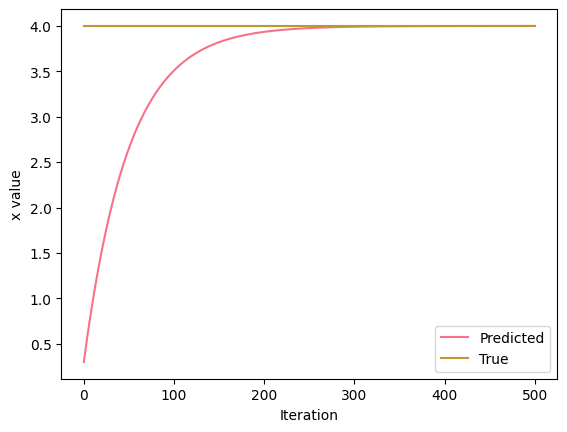

In [116]:
### Function minimization with autograd and gradient descent ###

# Initialize a random value for our intial x
x = torch.randn(1)
print(f"Initializing x={x.item()}")

learning_rate = 1e-2  # Learning rate
history = []
x_f = 4  # Target value


# We will run gradient descent for a number of iterations. At each iteration, we compute the loss,
#   compute the derivative of the loss with respect to x, and perform the update.
for i in range(500):
    x = torch.tensor([x], requires_grad=True)

    # Compute the loss as the square of the difference between x and x_f
    loss = (x - x_f) ** 2

    # Backpropagate through the loss to compute gradients
    loss.backward()

    # Update x with gradient descent
    x = x.item() - learning_rate * x.grad

    history.append(x.item())

# Plot the evolution of x as we optimize toward x_f!
plt.plot(history)
plt.plot([0, 500], [x_f, x_f])
plt.legend(('Predicted', 'True'))
plt.xlabel('Iteration')
plt.ylabel('x value')
plt.show()


# **Activity: Build a student pass/fail classifier**

Build and train a neural network to predict whether a student will pass or fail based on their study hours and attendance rate.

TASKS:
1. Load, explore, and visualize the dataset
2. Prepare the data (convert to tensors, split train/test)
3. Design a neural network architecture
4. Define loss function and optimizer
5. Train the model
6. Evaluate performance
7. Visualize results

### Task 1: Load, explore, and visualize the dataset  

In [117]:
# TASK 1: Load, explore, and visualize the dataset  

X, y, df = generate_pass_fail_dataset(n_samples=100, random_state=42)
df.describe()


,study_hours,attendance_rate,label
count,100.000000,100.000000,100.000000
mean,5.431198,67.658807,0.500000
std,2.698304,20.899229,0.502519
min,0.802004,20.555432,0.000000
25%,2.792714,52.934561,0.000000
50%,5.306389,72.586872,0.500000
75%,7.743968,83.819165,1.000000
max,9.876521,99.701818,1.000000


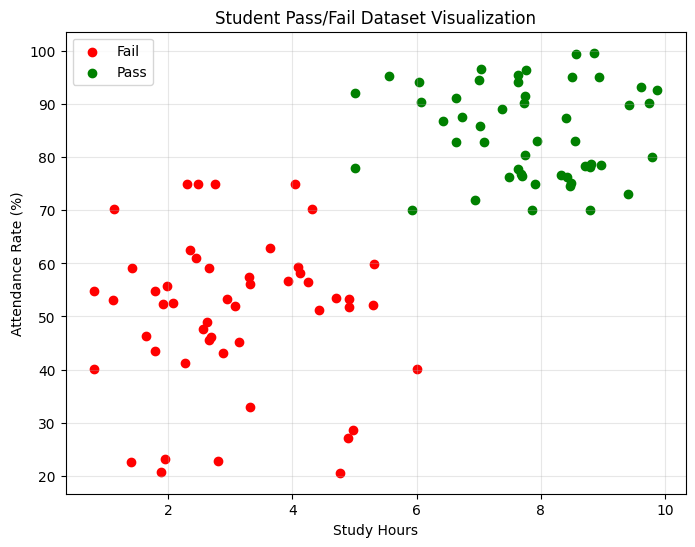

In [118]:
# Visualize custom dataset using scatterplot

plt.figure(figsize=(8,6))
plt.scatter(
    df.loc[df['label'] == 0, 'study_hours'],
    df.loc[df['label'] == 0, 'attendance_rate'],
    color='red', label='Fail'
)
plt.scatter(
    df.loc[df['label'] == 1, 'study_hours'],
    df.loc[df['label'] == 1, 'attendance_rate'],
    color='green', label='Pass'
)

plt.title('Student Pass/Fail Dataset Visualization')
plt.xlabel('Study Hours')
plt.ylabel('Attendance Rate (%)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

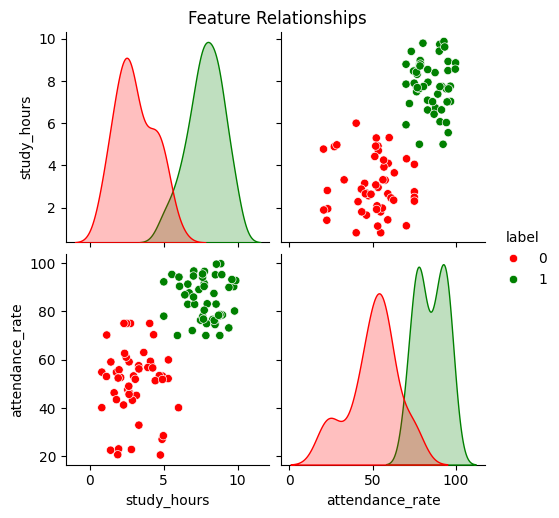

In [119]:
# Visualize dataset using pairplot to show feature relationships
sns.pairplot(df, hue='label', diag_kind='kde', palette=['red','green'])
plt.suptitle('Feature Relationships', y=1.02)
plt.show()

### Task 2: Prepare the data

In [120]:
from torch.utils.data import random_split, DataLoader
import torch.optim as optim # for the adam optimizer

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

print(X_tensor.shape)
print(y_tensor.shape)

n_samples = len(X_tensor)
test_size = int(0.2 * n_samples)
train_size = n_samples - test_size

indices = torch.randperm(n_samples)
train_idx, test_idx = indices[:train_size], indices[train_size:]

X_train_tensor, X_test_tensor = X_tensor[train_idx], X_tensor[test_idx]
y_train_tensor, y_test_tensor = y_tensor[train_idx], y_tensor[test_idx]

print(f"Train set: {X_train_tensor.shape}, Test set: {X_test_tensor.shape}")

torch.Size([100, 2])
torch.Size([100, 1])
Train set: torch.Size([80, 2]), Test set: torch.Size([20, 2])


### Task 3: Implement neural network architecture


In [121]:
# Applying the mentioned nn.Module above for a flexible and multi-layer model

class LinearWithReLUSigmoid(nn.Module):
    def __init__(self):
        super(LinearWithReLUSigmoid, self).__init__()
        self.fc1 = nn.Linear(2, 8)   # 2 input features -> 8 outpute neurons
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(8, 4)   # 8  -> 4 (hidden layer 1)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(4, 1)   # 4 -> 1 output (hidden later 2)
        self.activation = nn.Sigmoid()

    def forward(self, inputs):
        linear_output = self.relu1(self.fc1(inputs))
        linear_output = self.relu2(self.fc2(linear_output))
        output = self.activation(self.fc3(linear_output))
        return output

#  -- Architecture:
#  -- Input layer: 2 features (study_hours, attendance_rate)
#  -- Hidden layer: 8 neurons with ReLU activation
#  -- Hidden layer: 4 neurons with ReLU activation
#  -- Output layer: 1 neuron with Sigmoid activation (binary classification)

### Task 4: Implement Loss Function (BCE) and Adam optimizer

In [122]:
model = LinearWithReLUSigmoid()

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

# -- Loss function: Binary Cross-Entropy
# -- Optimizer: Adam

In [ ]:
# TASK 5: Train the model

In [ ]:
# TASK 6: Evaluate performance
# -- Predictions on test set
# -- Calculate accuracy

In [125]:
# TASK 7: Visualize results

# -- Plot training history
# -- Loss curves
# -- Decision boundary

**REFLECTION QUESTIONS:**

1. Why do we use sigmoid activation in the output layer for binary classification?

    > (write your answer here)



2. What would happen if we increased/decreased the number of hidden neurons?

    > (write your answer here)


3. How does the learning rate affect the training process?
> (write your answer here)

4. What other metrics besides accuracy could we use to evaluate our model?
    > (write your answer here)

5. How could we prevent overfitting if we noticed the test loss increasing?
    > (write your answer here)

---

## **Submission Instructions**

- Upload your completed Notebook to your **GitHub repository**.  
- Ensure the filename follows this format:  
  **`CSC173_Activity02_Lastname_Firstname.ipynb`**
- Make sure all code cells have been executed and outputs are visible.   
- Submit the **GitHub repository link** containing your notebook in the MOLE Assignment page.  
- **Deadline:** *November 3, 2025, 11:59 PM*

---
